In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from scipy.fft import fft
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import os

In [24]:
#Define a function that offsets all repeating WaterYear values
def duplicate_years(df):
    # Create a set to keep track of seen values and a dictionary for offsets
    seen = set()
    offsets = {}
    append = 0

    # Increment duplicates
    for idx, year in enumerate(df['WaterYear']):
        if year in seen:
            # Increment the year using the current offset for this value
            offsets[year] += 1
            df.at[idx, 'WaterYear'] = int(year + offsets[year])
        else:
            # First occurrence, initialize offset
            seen.add(year)
            offsets[year] = 0

    df['WaterYear'] = df['WaterYear'].astype('int')
    return df

In [25]:
# Load data
data = pd.read_csv('../Data/final_data_temp.csv')

In [26]:
# Convert WaterYear to date time format and set as index
data["Date"] = pd.to_datetime(data["WaterYear"].astype(str) + "-10-01")
data.set_index("Date", inplace=True)
grouped_data = data.groupby("County")

In [27]:
# Ensure the forecast directory exists
#output_dir = "../Station_Forecasts"
#os.makedirs(output_dir, exist_ok=True)
new_stations = []

In [28]:
# Creating rolling mean for time-series data
def create_rolling_mean(data, window_size=3):
    data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()
    return data

1961-10-01    48.30
1962-10-01    49.04
1963-10-01    54.24
1964-10-01    45.55
1965-10-01    93.25
1966-10-01    46.45
1967-10-01    66.24
1968-10-01    50.66
1969-10-01    76.91
1970-10-01    67.25
1971-10-01    74.83
1972-10-01    59.70
1973-10-01    65.48
1974-10-01    84.20
1975-10-01    71.45
1976-10-01    43.62
1977-10-01    29.62
1978-10-01    75.65
1979-10-01    45.01
1980-10-01    72.34
1981-10-01    40.20
1982-10-01    88.70
1983-10-01    96.95
1984-10-01    71.75
1985-10-01    58.28
1986-10-01    72.70
1987-10-01    47.20
1988-10-01    45.45
1989-10-01    58.40
1990-10-01    40.95
1991-10-01    37.09
1992-10-01    44.45
1993-10-01    80.96
1994-10-01    35.58
1995-10-01    93.75
1996-10-01    84.05
1997-10-01    85.43
1998-10-01    93.30
1999-10-01    68.57
2000-10-01    53.25
2001-10-01    41.70
2002-10-01    53.95
2003-10-01    66.45
2004-10-01    56.39
2005-10-01    70.05
2006-10-01    80.34
2007-10-01    52.78
2008-10-01    54.95
2009-10-01    44.30
2010-10-01    64.33


C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


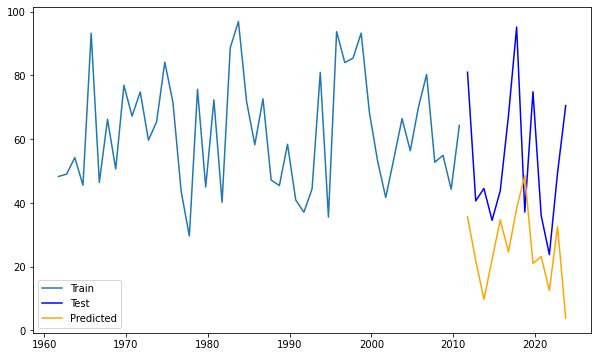

1948-10-01    25.120000
1949-10-01    16.000000
1950-10-01    21.360000
1951-10-01    22.030000
1952-10-01    28.060000
1953-10-01    22.530000
1954-10-01    18.070000
1955-10-01    14.060000
1956-10-01    31.370000
1957-10-01    21.610000
1958-10-01    28.750000
1959-10-01    18.502500
1960-10-01    21.560000
1961-10-01    23.358000
1962-10-01    24.852000
1963-10-01    35.782000
1964-10-01    24.712000
1965-10-01    36.782000
1966-10-01    21.430000
1967-10-01    34.282000
1968-10-01    25.318000
1969-10-01    33.504000
1970-10-01    33.360000
1971-10-01    38.872000
1972-10-01    26.466000
1973-10-01    25.468000
1974-10-01    42.126000
1975-10-01    33.536000
1976-10-01    20.834000
1977-10-01    14.450000
1978-10-01    31.884000
1979-10-01    19.182000
1980-10-01    31.530000
1981-10-01    21.722000
1982-10-01    46.522000
1983-10-01    41.994000
1984-10-01    31.708000
1985-10-01    27.154000
1986-10-01    33.996000
1987-10-01    20.450000
1988-10-01    20.240000
1989-10-01    25

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


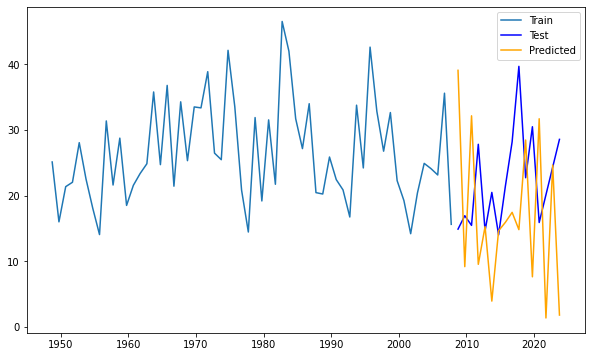

1959-10-01    21.149000
1960-10-01    17.401667
1961-10-01    16.664167
1962-10-01    18.330000
1963-10-01    28.208333
1964-10-01    21.098333
1965-10-01    26.638333
1966-10-01    16.275000
1967-10-01    25.931667
1968-10-01    18.738333
1969-10-01    31.260000
1970-10-01    25.698333
1971-10-01    35.170000
1972-10-01    26.725000
1973-10-01    23.600000
1974-10-01    30.246667
1975-10-01    26.563333
1976-10-01    23.466667
1977-10-01    14.545000
1978-10-01    30.891667
1979-10-01    21.430000
1980-10-01    31.620000
1981-10-01    21.083333
1982-10-01    36.350000
1983-10-01    35.606667
1984-10-01    33.481667
1985-10-01    22.293333
1986-10-01    32.411667
1987-10-01    19.720000
1988-10-01    23.125000
1989-10-01    27.208333
1990-10-01    21.200000
1991-10-01    22.460000
1992-10-01    15.570000
1993-10-01    38.065000
1994-10-01    20.711667
1995-10-01    38.326667
1996-10-01    34.965000
1997-10-01    32.070000
1998-10-01    42.548333
1999-10-01    30.083333
2000-10-01    20

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


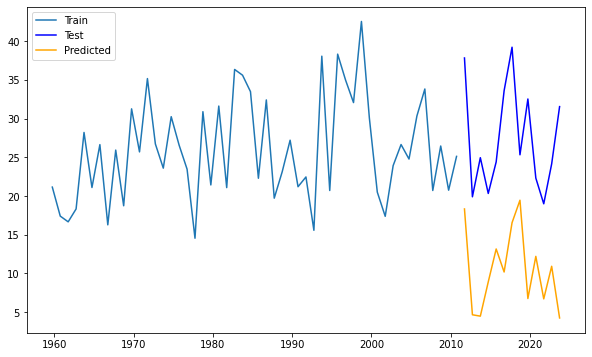

1959-10-01    17.100000
1960-10-01    28.504000
1961-10-01    24.772000
1962-10-01    28.620000
1963-10-01    46.798000
1964-10-01    24.630000
1965-10-01    46.823333
1966-10-01    22.682857
1967-10-01    44.311429
1968-10-01    30.135000
1969-10-01    50.470000
1970-10-01    43.064000
1971-10-01    44.823000
1972-10-01    30.777000
1973-10-01    33.968000
1974-10-01    52.028000
1975-10-01    37.865000
1976-10-01    21.400000
1977-10-01    14.471000
1978-10-01    45.208000
1979-10-01    28.348000
1980-10-01    42.824000
1981-10-01    24.635000
1982-10-01    57.903000
1983-10-01    60.669000
1984-10-01    43.284000
1985-10-01    30.540000
1986-10-01    44.822000
1987-10-01    23.228000
1988-10-01    20.697000
1989-10-01    35.371000
1990-10-01    27.689000
1991-10-01    25.809000
1992-10-01    19.937000
1993-10-01    44.452000
1994-10-01    19.078000
1995-10-01    61.027000
1996-10-01    39.164000
1997-10-01    42.557000
1998-10-01    46.420000
1999-10-01    29.425000
2000-10-01    30

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


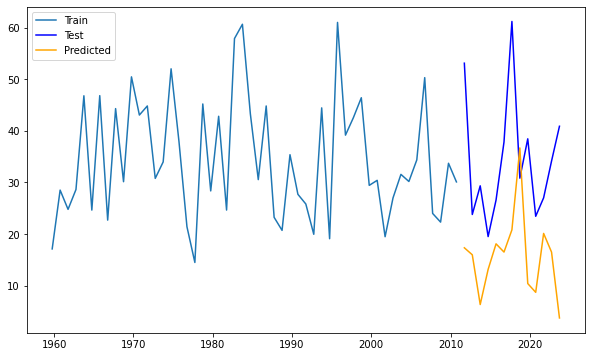

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


1947-10-01     68.17
1948-10-01     89.91
1949-10-01     60.55
1950-10-01     57.50
1951-10-01    109.70
1952-10-01    109.16
1953-10-01     88.50
1954-10-01     41.10
1955-10-01     64.40
1956-10-01    121.15
1957-10-01     69.70
1958-10-01    143.83
1959-10-01     75.85
1960-10-01     79.85
1961-10-01     83.50
1962-10-01     84.37
1963-10-01    116.14
1964-10-01     61.03
1965-10-01    102.75
1966-10-01     81.64
1967-10-01    113.39
1968-10-01     56.82
1969-10-01    115.89
1970-10-01    108.70
1971-10-01     98.12
1972-10-01     56.18
1973-10-01     86.99
1974-10-01    158.93
1975-10-01     87.35
1976-10-01     51.54
1977-10-01     22.25
1978-10-01    153.66
1979-10-01     46.24
1980-10-01     97.78
1981-10-01     62.45
1982-10-01    137.80
1983-10-01    139.03
1984-10-01     86.25
1985-10-01     47.64
1986-10-01    104.25
1987-10-01     58.77
1988-10-01     58.15
1989-10-01     70.10
1990-10-01     55.95
1991-10-01     42.84
1992-10-01     55.18
1993-10-01    111.15
1994-10-01   

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


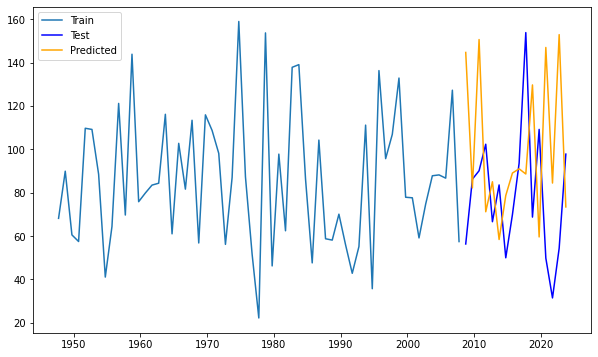

1947-10-01    34.860000
1948-10-01    56.475000
1949-10-01    38.155000
1950-10-01    41.245000
1951-10-01    56.575000
1952-10-01    69.020000
1953-10-01    59.000000
1954-10-01    56.715000
1955-10-01    48.977500
1956-10-01    74.410000
1957-10-01    38.983333
1958-10-01    65.376667
1959-10-01    38.016667
1960-10-01    31.706667
1961-10-01    40.990000
1962-10-01    35.472222
1963-10-01    58.771111
1964-10-01    33.803333
1965-10-01    49.500000
1966-10-01    41.683333
1967-10-01    55.153333
1968-10-01    34.333333
1969-10-01    51.446667
1970-10-01    44.896667
1971-10-01    50.596667
1972-10-01    40.463333
1973-10-01    39.360000
1974-10-01    68.956667
1975-10-01    43.560000
1976-10-01    33.153333
1977-10-01    18.363333
1978-10-01    65.896667
1979-10-01    33.186667
1980-10-01    45.066667
1981-10-01    34.316667
1982-10-01    63.850000
1983-10-01    74.315000
1984-10-01    45.380000
1985-10-01    30.910000
1986-10-01    51.270000
1987-10-01    33.693333
1988-10-01    40

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


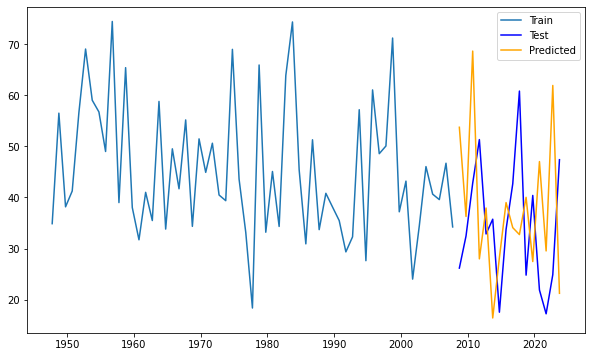

1945-10-01    15.350000
1946-10-01    30.200000
1947-10-01    23.255000
1948-10-01    37.990000
1949-10-01    27.140000
1950-10-01    27.560000
1951-10-01    37.996667
1952-10-01    46.053333
1953-10-01    39.880000
1954-10-01    39.626667
1955-10-01    25.696667
1956-10-01    54.193333
1957-10-01    30.870000
1958-10-01    59.686667
1959-10-01    22.343333
1960-10-01    25.890000
1961-10-01    27.976000
1962-10-01    29.666000
1963-10-01    36.758000
1964-10-01    21.212000
1965-10-01    40.638000
1966-10-01    24.980000
1967-10-01    40.552000
1968-10-01    27.952000
1969-10-01    51.846000
1970-10-01    41.086000
1971-10-01    37.854000
1972-10-01    26.056000
1973-10-01    41.570000
1974-10-01    50.500000
1975-10-01    37.740000
1976-10-01    19.242000
1977-10-01    17.214000
1978-10-01    41.806000
1979-10-01    25.388000
1980-10-01    41.748000
1981-10-01    26.400000
1982-10-01    46.030000
1983-10-01    66.130000
1984-10-01    41.215000
1985-10-01    25.976000
1986-10-01    40

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


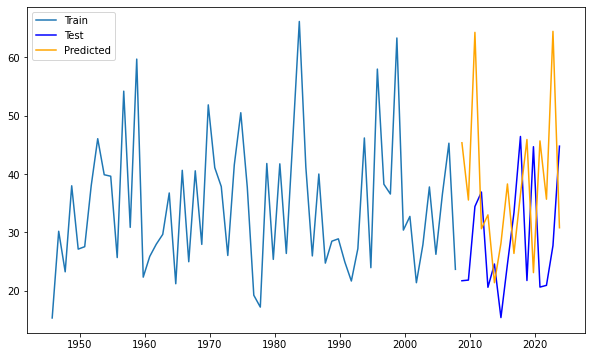

1947-10-01     40.46
1948-10-01     61.68
1949-10-01     42.86
1950-10-01     33.40
1951-10-01     56.61
1952-10-01     58.75
1953-10-01     67.63
1954-10-01     67.80
1955-10-01     31.30
1956-10-01     77.05
1957-10-01     50.21
1958-10-01     94.85
1959-10-01     45.65
1960-10-01     54.15
1961-10-01     56.60
1962-10-01     50.71
1963-10-01     68.91
1964-10-01     40.68
1965-10-01     63.52
1966-10-01     57.09
1967-10-01     70.54
1968-10-01     49.20
1969-10-01     72.66
1970-10-01     65.37
1971-10-01     69.23
1972-10-01     54.40
1973-10-01     55.44
1974-10-01    102.16
1975-10-01     72.47
1976-10-01     41.64
1977-10-01     22.34
1978-10-01     78.77
1979-10-01     40.75
1980-10-01     65.80
1981-10-01     44.30
1982-10-01     81.65
1983-10-01     93.83
1984-10-01     58.25
1985-10-01     41.80
1986-10-01     70.37
1987-10-01     49.88
1988-10-01     49.35
1989-10-01     51.00
1990-10-01     37.90
1991-10-01     33.02
1992-10-01     47.60
1993-10-01     76.67
1994-10-01   

C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\dfang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


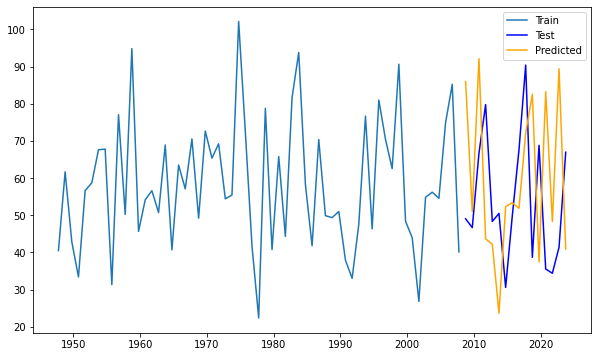

In [29]:
station_names = []
errors_list_ts = []
# Loop through each unique station and create a model - SARIMAX
for station in list(grouped_data):
    station_name = station[0]
    station_names.append(station_name)
    station = station[1]
    
    # Resample Station data to ensure consistent frequency and fill any missing dates
    station = duplicate_years(station)
    station.index = pd.to_datetime(station["WaterYear"].astype(str) + "-10-01")
    station = create_rolling_mean(station, window_size = 5)

    # Train SARIMAX model with reduced complexity for sparse data
    series = station["TotalPrecipitation_inches"]
    series = series.dropna()

    # Group by date (not datetime) and average
    df_grouped = series.groupby(series.index.date).mean()

    # Convert index back to datetime for further operations (optional)
    df_grouped.index = pd.to_datetime(df_grouped.index)

    # Print the result
    print(df_grouped.to_string())

    series = df_grouped

    # Split data into train and test sets
    split_index = int(len(series) * 0.8)
    train = series[:split_index]
    test = series[split_index:]

    model = SARIMAX(
        train,
        order=(1, 1, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    model_fit = model.fit(disp=False)
    # Forecast for the test period
    forecast = model_fit.forecast(steps=len(test))

    # Convert forecast and test data to DataFrames for comparison
    test_forecast = pd.DataFrame({'Actual': test, 'Predicted': forecast}, index=test.index)

    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    r_sq = r2_score(test, forecast)

    errors_list_ts.append([mae, rmse, r_sq])

    plt.figure(figsize=(10, 6))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test', color='blue')
    plt.plot(test_forecast['Predicted'], label='Predicted', color='orange')
    plt.legend()
    plt.show()
    

In [30]:
new_df_ts = pd.DataFrame(errors_list_ts, columns = ['mae', 'rmse', 'r_sq'])
new_df_ts.index = station_names
new_df_ts['county'] = new_df_ts.index
print(new_df_ts)

                mae       rmse      r_sq    county
Glen      30.223624  36.131019 -2.027099      Glen
Lassen    13.505523  16.145475 -4.311818    Lassen
Modoc     16.812480  18.026073 -6.500702     Modoc
Plumas    19.513138  22.964570 -2.919454    Plumas
Shasta    45.403568  54.510448 -2.596161    Shasta
Siskiyou  17.887161  20.340721 -1.854548  Siskiyou
Tehama    16.785265  18.992386 -2.856986    Tehama
Trinity   25.393313  29.088364 -1.985166   Trinity


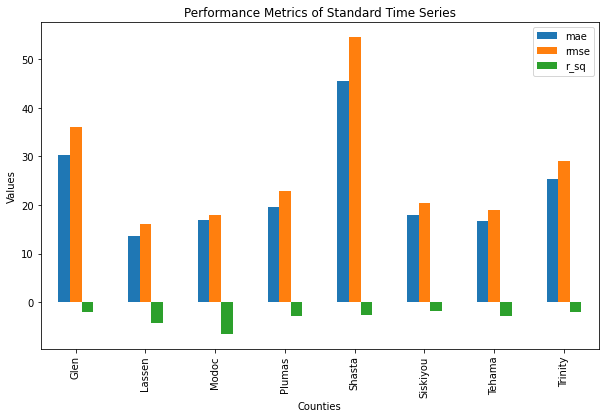

In [31]:
new_df_ts.plot(x='county', y=['mae', 'rmse', 'r_sq'], kind='bar', figsize=(10, 6))

plt.xlabel('Counties')
plt.ylabel('Values')
plt.title('Performance Metrics of Standard Time Series')
plt.legend()

# Show plot
plt.show()

In [32]:
# Creating lag features for time-series data
def create_lag_features(data, lag_steps=1):
    for i in range(1, lag_steps + 1):
        data[f'lag_{i}'] = data["TotalPrecipitation_inches"].shift(i)
    return data

In [33]:
# Creating rolling mean for time-series data
def create_rolling_mean(data, window_size=3):
    data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()
    return data

In [34]:
# Applying Fourier transformation for capturing seasonality
def apply_fourier_transform(data):
    values = data['TotalPrecipitation_inches'].values
    fourier_transform = fft(values)
    data['fourier_transform'] = np.abs(fourier_transform)
    return data

In [76]:
def forecast_future(data, model, steps=10):
    """
    Forecast future values using the XGBoost model and lagged features. (Imported from model_RF.py)
    """
    future_forecast = []
    # Start with the last row of data
    last_known = station['rolling_mean'].tail(5)

    for _ in range(steps):
        input_data = pd.DataFrame([last_known], columns=['rolling_mean'])
        next_pred = model.predict(input_data)[0]
        future_forecast.append(next_pred)

        # Update the input with the new prediction (rolling window)
        last_known = np.roll(last_known, -1)
        last_known[-1] = next_pred  # Add the predicted value to the input

    return future_forecast

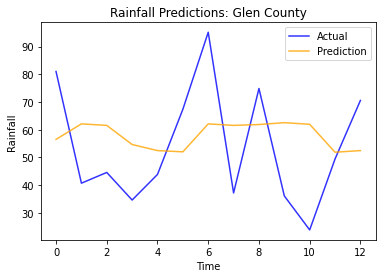

C:\Users\dfang\AppData\Local\Temp\ipykernel_43168\2114243854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()


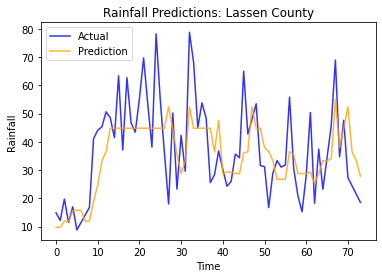

C:\Users\dfang\AppData\Local\Temp\ipykernel_43168\2114243854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()


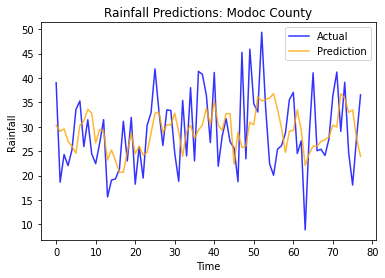

C:\Users\dfang\AppData\Local\Temp\ipykernel_43168\2114243854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()


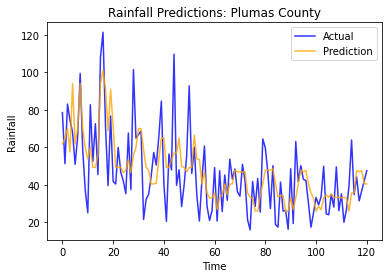

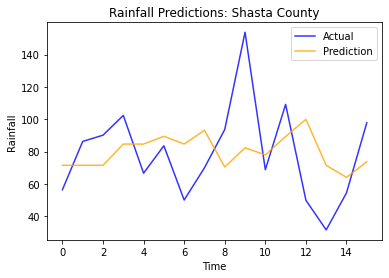

C:\Users\dfang\AppData\Local\Temp\ipykernel_43168\2114243854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()


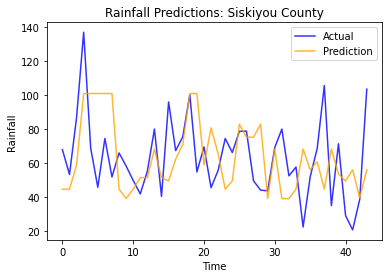

C:\Users\dfang\AppData\Local\Temp\ipykernel_43168\2114243854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data["TotalPrecipitation_inches"].rolling(window=window_size).mean()


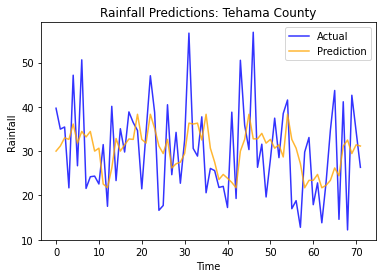

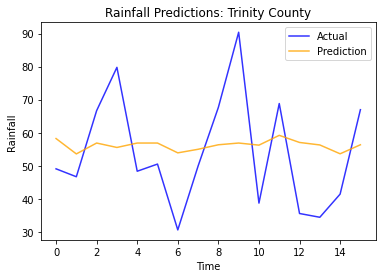

In [47]:
errors_list = []
models_list = []
stations_list = []
stations_names = []
for station in list(grouped_data):
    station_maes = []
    station_rmses = []

    station_name = station[0]
    stations_names.append(station_name)
    station = station[1]
    # Resample Station data to ensure consistent frequency and fill any missing dates
    station = duplicate_years(station)
    station = station.dropna()
    station.index = pd.to_datetime(station["WaterYear"].astype(str) + "-10-01")
    '''
    try:
        station = station.resample("YS-OCT").asfreq()
    except:
        print(station.to_string())
    '''

    # Applying lag feature creation to the dataset
    #station = create_lag_features(station, lag_steps = 5)
    # Applying rolling mean to the dataset
    station = create_rolling_mean(station, window_size = 5)
    #station = apply_fourier_transform(station)

    #X1 = station[['lag_1', 'lag_2', 'lag_3']]
    X2 = station['rolling_mean'] #We picked the rolling mean because precipitation data is susceptible to unnecessary trends (record high/low rainfall years)
    #X3 = station['fourier_transform']
    y = station['TotalPrecipitation_inches']

    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, shuffle=False)

    param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
    grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    # Training the XGBoost model
    xgb_model = XGBRegressor(**best_params)
    xgb_model.fit(X_train, y_train)

    # Evaluating the XGBoost model on the testing set
    predictions = xgb_model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r_sq = r2_score(y_test, predictions)

    errors_list.append([mae, rmse, r_sq])

    stations_list.append(station)
    models_list.append(xgb_model)

    #plt.plot(y_train.values, label = 'Training', color = 'green', alpha = 0.8)

    # Plot actual values
    plt.plot(y_test.values, label='Actual', color='blue', alpha=0.8)

    # Plot predicted values
    plt.plot(predictions, label='Prediction', color='orange', alpha=0.8)

    plt.xlabel('Time')
    plt.ylabel('Rainfall')
    plt.title('Rainfall Predictions: {} County'.format(station_name))
    plt.legend()
    plt.show()

In [ ]:
'''
i = 0
for station in stations_list:
    # Generate forecasts for the next 80 years
    forecast_years = 80
    future_forecast = forecast_future(station, models_list[i], steps=forecast_years)

    # Create future dates
    future_dates = pd.date_range(
        start=station.index[-1] + pd.DateOffset(years=1),
        periods=forecast_years,
        freq="AS-OCT"
    )

    # Combine into a DataFrame
    forecast_df = pd.DataFrame({
        "Date": future_dates,
        "Predicted_Precipitation": future_forecast
    }).set_index("Date")

    # Define output file path
    output_path = f"../County_Forecasts/{stations_names[i]}_XGBforecast.txt"

    # Save the forecast to a text file
    with open(output_path, "w") as f:
        f.write(f"Precipitation Forecast for {stations_names[i]} County:\n")
        for date, value in forecast_df["Predicted_Precipitation"].items():
            f.write(f"{date.strftime('%Y-%m-%d')}: {value:.2f} inches\n")

    print(f"Forecast for {stations_names[i]} County saved to {output_path}")
    i += 1
'''

ValueError: 1 columns passed, passed data had 5 columns

The discrepancies in the length of the XGBoost temperature indices stem from the length of the county data.

In [ ]:
new_df = pd.DataFrame(errors_list, columns = ['mae', 'rmse', 'r_sq'])
new_df.index = station_names
new_df['county'] = new_df.index
print(new_df)

                mae       rmse      r_sq    county
Glen      20.214743  22.219988 -0.144864      Glen
Lassen    10.082355  12.860494  0.413594    Lassen
Modoc      6.254274   7.660570  0.050713     Modoc
Plumas    12.547216  15.903096  0.435280    Plumas
Shasta    24.715923  29.696614 -0.067317    Shasta
Siskiyou  21.873047  27.546156 -0.455507  Siskiyou
Tehama     8.194160   9.785383  0.109458    Tehama
Trinity   14.486769  16.506762  0.038712   Trinity


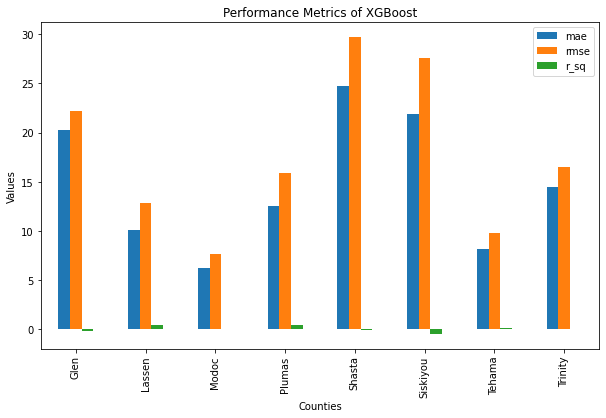

In [ ]:
new_df.plot(x='county', y=['mae', 'rmse', 'r_sq'], kind='bar', figsize=(10, 6))

plt.xlabel('Counties')
plt.ylabel('Values')
plt.title('Performance Metrics of XGBoost')
plt.legend()

# Show plot
plt.show()